In [556]:
import altair as alt
import numpy as np
import polars as pl
import pandas as pd
import pyarrow
from vega_datasets import data
import datetime as dt
import vl_convert as vlc
from altair_saver import save


In [557]:
AIAN_deaths = pl.read_csv("data/AIAN_drds_state.csv")

# Need to make sure our FIPS codes are read as strings
def pad_code(int):
    """
    Takes:
        int (int): An integer, often a FIPS code that is displaying as a integer
        that we need to convert to a 5-character string

    Returns:
        out (str): A 5-digit fips code string. If the integer given was less than five
        a 0 is added up front.
    """
    string = str(int)
    #if len(string) < 2:
    #   string = "".join(["0", string])
    
    return string

def make_juris_labels(int):
    """
    This function recodes 0,1 into string labels for displaying the charts.

    Takes:
        int (int): A 0 or 1 value that is meant to indicate if the state or Tribal
        Authority has criminal jurisdiction on Native American Lands.
    Returns:
        out (str): A string that is either "State" or "Tribal Authority"
    """
    out = "Unknown"
    if int == 1:
        out = "State"
    if int == 0:
        out = "Tribal Authority"
    
    return out

#These two lines create new variables where instead of using the rate of deaths, we adjust it to be the number of Drug-Related
# deaths per 100,000 persons.
AIAN_deaths = AIAN_deaths.with_columns((pl.col("OD_rate_AIAN")*100000).round(decimals = 3).alias("drd_AIAN_p100k"))
AIAN_deaths = AIAN_deaths.with_columns((pl.col("OD_rate_non_AIAN")*100000).round(decimals = 3).alias("drd_non_p100k"))

# We use our functions define above to adjust FIPS codes to be strings and to reforumate our state_crim variable to be a string.
AIAN_deaths = AIAN_deaths.with_columns(pl.col("state_code").map_elements(pad_code).alias("id"))
AIAN_deaths = AIAN_deaths.with_columns(pl.col("state_crim").map_elements(make_juris_labels
                                                                         ).alias("Jurisdiction"))

#Reads in a dataset of state centroids
centroids = pl.read_csv("data/world_country_and_usa_states_latitude_and_longitude_values.csv")
#drop empty values
centroids = centroids.filter(pl.col("usa_state_latitude").is_not_null())
#Rename variables for the merge
centroids = centroids.with_columns(pl.col("usa_state_code").alias("State"),
                                   pl.col("usa_state_latitude").alias("latitude"),
                                   pl.col("usa_state_longitude").alias("longitude"))
centroids = centroids["State", "latitude", "longitude"]
#Merge in Centroids for use with Maps
AIAN_deaths = AIAN_deaths.join(centroids, "State", "left")

/var/folders/p9/6789_cm149s8kj127lfbgwy40000gn/T/ipykernel_52370/3998254881.py:44: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  AIAN_deaths = AIAN_deaths.with_columns(pl.col("state_code").map_elements(pad_code).alias("id"))
/var/folders/p9/6789_cm149s8kj127lfbgwy40000gn/T/ipykernel_52370/3998254881.py:45: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  AIAN_deaths = AIAN_deaths.with_columns(pl.col("state_crim").map_elements(make_juris_labels


In [558]:
county_drd = pl.read_csv("data/drd_by_county.csv", ignore_errors=True)
counties = alt.topo_feature(data.us_10m.url, 'counties')
county_centroids = pl.read_csv("data/County Centroids.csv")
county_centroids= county_centroids.with_columns(pl.col("cfips").alias("County.Code"))["County.Code", "latitude", "longitude"]
county_drd = county_drd.join(county_centroids, "County.Code", "left")

def pad_code_5(int):
    string = str(int)
    if len(string) < 5:
       string = "".join(["0", string])
    
    return string


def consolidate_counties(state_abb, filter = True, df = county_drd):

    if filter ==True:
        df= df.filter(pl.col("state_abb")==state_abb)
    df = df.with_columns(pl.col("state_crim").map_elements(make_juris_labels).alias("Jurisdiction"),
                         pl.col("County.Code").map_elements(pad_code_5).alias("id"),
                         (pl.col("OD_rate_AIAN")*100000).alias("drd_AIAN_p100k"))
    
    df = df.group_by("id").agg(
            pl.col("drd_AIAN_p100k").mean(),
            pl.col("Jurisdiction").first(),
            pl.col("cnty_name").first(),
            pl.col("latitude").first(),
            pl.col("longitude").first())
    
    return df

county_drd = county_drd.with_columns((pl.col("OD_rate_AIAN")*100000).round(decimals = 3).alias("drd_AIAN_p100k"))
county_drd = county_drd.with_columns((pl.col("OD_rate_non_AIAN")*100000).round(decimals = 3).alias("drd_non_p100k"))
county_drd = county_drd.with_columns(pl.col("state_crim").map_elements(make_juris_labels
                                                                         ).alias("Jurisdiction"))

/var/folders/p9/6789_cm149s8kj127lfbgwy40000gn/T/ipykernel_52370/2418820009.py:34: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  county_drd = county_drd.with_columns(pl.col("state_crim").map_elements(make_juris_labels


In [559]:
def group_years_juris(df = AIAN_deaths):

    grouped_df = df.group_by("Year", "Jurisdiction").agg(pl.col("population_AIAN").sum(),
                                                   pl.col("deaths_AIAN").sum(),
                                                   pl.col("pop_non_AIAN").sum(),
                                                   pl.col("deaths_non_AIAN").sum())
    
    grouped_df = grouped_df.with_columns((100000*pl.col("deaths_AIAN")/pl.col("population_AIAN")
                                          ).alias("drd_AIAN_p100k"),
                                          (100000*pl.col("deaths_non_AIAN")/pl.col("pop_non_AIAN")
                                          ).alias("drd_non_p100k"))

    return grouped_df

def group_states_years(df = AIAN_deaths):

    grouped_df = df.group_by("state_abb", "Year").agg(pl.col("population_AIAN").sum(),
                                                   pl.col("deaths_AIAN").sum(),
                                                   pl.col("pop_non_AIAN").sum(),
                                                   pl.col("deaths_non_AIAN").sum())
    
    grouped_df = grouped_df.with_columns((100000*pl.col("deaths_AIAN")/pl.col("population_AIAN")
                                        ).alias("drd_AIAN_p100k"),
                                        (100000*pl.col("deaths_non_AIAN")/pl.col("pop_non_AIAN")
                                        ).alias("drd_non_p100k"))

    return grouped_df


In [560]:
# These Functions are for use on AIAN Deaths, each of them apply operations
# to slice the data in ways that makes them useful for data visualizations
def group_states(df = AIAN_deaths, grp = "State"):

    grouped_df = df.group_by(grp).agg(pl.col("population_AIAN").sum(),
                                                   pl.col("deaths_AIAN").sum(),
                                                   pl.col("Jurisdiction").first(),
                                                   pl.col("id").first(),
                                                   pl.col("latitude").first(),
                                                   pl.col("longitude").first(),
                                                   pl.col("pop_non_AIAN").sum(),
                                                   pl.col("deaths_non_AIAN").sum())
    
    grouped_df = grouped_df.with_columns((100000*pl.col("deaths_AIAN")/pl.col("population_AIAN")
                                        ).alias("drd_AIAN_p100k"),
                                        (100000*pl.col("deaths_non_AIAN")/pl.col("pop_non_AIAN")
                                        ).alias("drd_non_p100k"))

    return grouped_df

def group_years(df = AIAN_deaths):

    grouped_df = df.group_by("Year", "Jurisdiction").agg(pl.col("population_AIAN").sum(),
                                                   pl.col("deaths_AIAN").sum(),
                                                   pl.col("pop_non_AIAN").sum(),
                                                   pl.col("deaths_non_AIAN").sum())
    
    grouped_df = grouped_df.with_columns((100000*pl.col("deaths_AIAN")/pl.col("population_AIAN")
                                          ).alias("drd_AIAN_p100k"),
                                          (100000*pl.col("deaths_non_AIAN")/pl.col("pop_non_AIAN")
                                          ).alias("drd_non_p100k"))

    return grouped_df

def group_all_years(df = AIAN_deaths):

    grouped_df = df.group_by("Year").agg(pl.col("population_AIAN").sum(),
                                                   pl.col("deaths_AIAN").sum(),
                                                   pl.col("pop_non_AIAN").sum(),
                                                   pl.col("deaths_non_AIAN").sum())
    
    grouped_df = grouped_df.with_columns((100000*pl.col("deaths_AIAN")/pl.col("population_AIAN")
                                          ).alias("drd_AIAN_p100k"),
                                          (100000*pl.col("deaths_non_AIAN")/pl.col("pop_non_AIAN")
                                          ).alias("drd_non_p100k"))

    return grouped_df

def pivot_long():
    df = pl.read_csv("data/AIAN_drds_state.csv")
    df = df["Jurisdiction", "State", "Year", "OD_rate_AIAN"]
    df.pivot(columns = "state_crim", index=["State", "Year"], values = "OD_rate_AIAN")
    return df

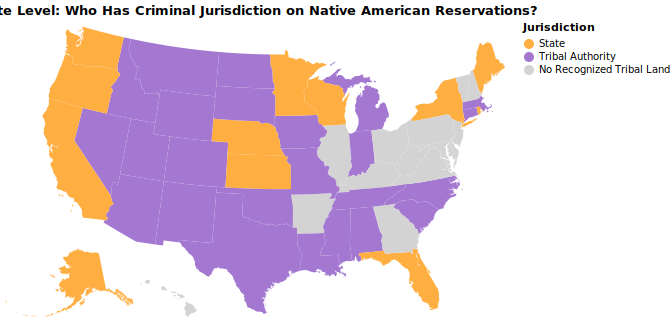

In [561]:
def map_states():
    df = group_states()
    df = df.to_pandas()
    states = alt.topo_feature(data.us_10m.url, 'states')
    default_value = "No Recognized Tribal Lands"

    full_map = alt.Chart(states).mark_geoshape().encode(
        color=  alt.condition(
            alt.datum.value == default_value,
            alt.value('white'),  # Default color
            alt.Color('Jurisdiction:N', scale=alt.Scale(
            domain = ["State", "Tribal Authority", "No Recognized Tribal Lands"],
            range = ["#FFAE42", '#a478d1', "lightgrey"]
            ))
        )
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(df, 'id', list(df.columns)),
        default = default_value
    ).properties(
        width=500,
        height=300,
        title = "State Level: Who Has Criminal Jurisdiction on Native American Reservations?"
    ).project(
        type='albersUsa'
    )

    return full_map

# formerly "#7c309aa3"
alt.renderers.enable("svg")
vis1 =map_states()
vis1.save("vis1.svg", embed_options={'renderer': 'svg'})
vis1

In [562]:
states = alt.topo_feature(data.us_10m.url, 'states')
counties = alt.topo_feature(data.us_10m.url, 'counties')

def map_counties():
    df = consolidate_counties("", filter= False)
    fips_str = str(df["id"][0])[0:2]
    #fips_int = int(fips_str)
    df = df.with_columns(pl.col("id").map_elements(int))


    state_outline = alt.Chart(states).mark_geoshape(
        fill='lightgray',
        stroke='white',
        strokeWidth=0.5
    ).project('albersUsa')

    #default_value = "No Tribal Lands"
    county_map = alt.Chart(counties).mark_geoshape(
        #stroke='white',
        #strokeWidth=0.5
    ).encode(
            color = alt.Color('Jurisdiction:N', scale=alt.Scale(
            domain = ["State", "Tribal Authority", "No Recognized Tribal Lands"],
            range = ["#FFAE42", "#a478d1", "lightgrey"]))
    ).transform_lookup(
        lookup = 'id',
        from_=alt.LookupData(df, 'id', df.columns)
        #default = default_value
    ).transform_calculate(state_id = "(datum.id / 1000)|0"
    ).project('albersUsa')
    full_map = (state_outline + county_map).properties(
        width=500,
        height=300,
        title = "County Level: Who Has Criminal Jurisdiction on Native American Reservations?"
    )
    return full_map

vis2 = map_counties()
vis2.save("vis2.svg")

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/var/folders/p9/6789_cm149s8kj127lfbgwy40000gn/T/ipykernel_52370/2117458057.py:8: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(pl.col("id").map_elements(int))


In [563]:
states = alt.topo_feature(data.us_10m.url, 'states')
counties = alt.topo_feature(data.us_10m.url, 'counties')
# This source helped me understand how to pass a filter to Js
# https://stackoverflow.com/questions/55336762/filtering-to-state-level-for-choropleth-maps-in-altair 

def map_county(state_abb):

    df = consolidate_counties(state_abb)
    fips_str = str(df["id"][0])[0:2]
    fips_int = int(fips_str)
    df = df.with_columns(pl.col("id").map_elements(int))

    state_outline = alt.Chart(states).mark_geoshape(
        fill='lightgray',
        stroke='white',
        strokeWidth=0.5
    ).transform_filter(
        alt.datum.id == fips_int
    ).project('albersUsa')

    default_value = "No Tribal Lands"
    county_map = alt.Chart(counties).mark_geoshape(
        stroke='white',
        strokeWidth=0.5
    ).encode(
            color = alt.condition(
                alt.datum.value == default_value,
                alt.value('lightgray'),  # Default color
                alt.Color('Jurisdiction:N', scale=alt.Scale(
            domain = ["State", "Tribal Authority", "No Recognized Tribal Lands"],
            range = ["#FFAE42", "#a478d1", "lightgrey"])))
    ).transform_lookup(
        lookup = 'id',
        from_=alt.LookupData(df, 'id', df.columns),
        default = default_value
    ).transform_calculate(state_id = "(datum.id / 1000)|0"
    ).transform_filter((alt.datum.state_id==fips_int)
    ).project('albersUsa')
    full_map = state_outline + county_map

    return full_map

vis3 = map_county("OR").properties(title = "Oregon: In Some Counties Tribal Authorities Have Criminal Jurisdiction")
vis3.save('vis3.svg')

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/var/folders/p9/6789_cm149s8kj127lfbgwy40000gn/T/ipykernel_52370/2164686968.py:11: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(pl.col("id").map_elements(int))


In [564]:
prop_scores_st = pl.read_csv("data/z_table_states.csv")
prop_scores_cnt = pl.read_csv("data/z_table_county.csv")
prop_scores_cnt= prop_scores_cnt.with_columns(
    (pl.col("OD_rate_AIAN") * 1000000).map_elements(round)/10,
    (pl.col("CI_lower") * 1000000).map_elements(round)/10,
    (pl.col("CI_upper") * 1000000).map_elements(round)/10)

def show_z(df):
    bar = alt.Chart(df).mark_errorbar().encode(
        alt.X("CI_upper:Q").scale(zero=False).title(""),
        alt.X2("CI_lower:Q"),
        alt.Y("Jurisdiction:N"),
    )

    point = alt.Chart(df).mark_point(
        filled=True,
        color="purple"
    ).encode(
        alt.X("OD_rate_AIAN:Q", title = "AIAN Drug-Related Death Rate per 100k Persons"),
        alt.Y("Jurisdiction:N")
    )

    point_text = alt.Chart(df).mark_text(
        align='center',
        baseline='bottom',
        dy= -5 
    ).encode(
    x='OD_rate_AIAN:Q',
    y='Jurisdiction:N',
    text=alt.Text("OD_rate_AIAN:Q"))

    bar_text_upper = alt.Chart(df).mark_text(
        align='center',
        baseline='bottom',
        dy= 15,
        dx = 3
    ).encode(
    alt.X('CI_upper:Q'),
    y='Jurisdiction:N',
    text=alt.Text("CI_upper:Q"))

    bar_text_lower = alt.Chart(df).mark_text(
        align='center',
        baseline='bottom',
        dy= 15,
        dx = 0 
    ).encode(
    alt.X('CI_lower:Q'),
    y='Jurisdiction:N',
    text=alt.Text("CI_lower:Q"))

    chart = (bar + point).properties(
        title = "The AIAN Drug-Related Death Rate is Higher Where Tribes Lack Criminal Jurisdiction",
        width = 400,
        height = 200
        ).configure_axis(
        grid=False,           
    )    
    return chart + point_text + bar_text_upper + bar_text_lower


vis4 = show_z(prop_scores_cnt)
vis4.save('vis4.svg')

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


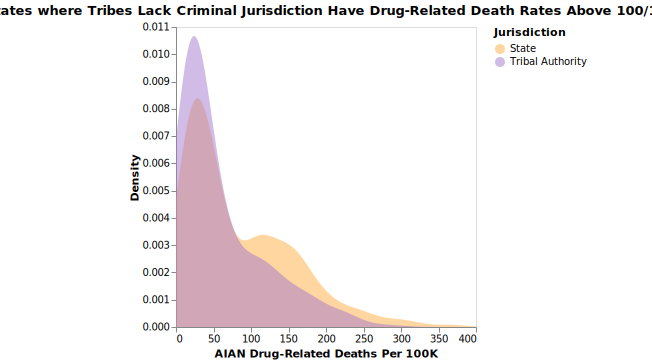

In [571]:
alt.data_transformers.disable_max_rows()

def pl280_density():
    # There can be a lot of small population outliers when using county death rates
    # Weighting by population controls for them in the aggregate, but when
    # using individual counties as data points its important to filter them out
    #df = county_drd.filter(pl.col("drd_AIAN_p100k"))
    df = AIAN_deaths
    density_plot = alt.Chart(df).transform_density(
        'drd_AIAN_p100k',
        counts = False,
        groupby = ["Jurisdiction"],
        as_ = ['AIAN Drug-Related Deaths Per 100K', 'Density'],
        bandwidth = 20,
        extent = [0, 400],
        #steps = 200
    ).mark_area(
        opacity = 0.5
    ).encode(
    x=alt.X("AIAN Drug-Related Deaths Per 100K:Q").title("AIAN Drug-Related Deaths Per 100K"),
    y= alt.Y('Density:Q').stack(None),
    color = alt.Color('Jurisdiction:N', scale=alt.Scale(
            domain = ["State", "Tribal Authority"],
            range = ["#FFAE42", "#a478d1"])
    )).configure_axis(
    grid=False
    )

    full_plot = (density_plot).properties(
        title = "More States where Tribes Lack Criminal Jurisdiction Have Drug-Related Death Rates Above 100/100,000"
    )

    return full_plot

pl280_density()

vis5 = pl280_density()
vis5.save('vis5.svg')
vis5

In [566]:

def juris_years_counties():
    df = group_years_juris(df= county_drd)

    chart = alt.Chart(df).mark_line().encode(
        x = alt.X('Year:Q', axis=alt.Axis(format='d')),
        y = alt.Y("drd_AIAN_p100k:Q", title = "AIAN Drug-Related Death Rate per 100k persons"),
        color = alt.Color("Jurisdiction:N", scale=alt.Scale(
            domain = ["State", "Tribal Authority"],
            range = ["#FFAE42", "#a478d1"]
            ))).configure_axis(
        grid=False            
    ).properties(
        title = "AIAN Drug-Related Death Rates Increasing Regularly Since the Onset of the Opiods Epidemic"
    )

    return chart

vis6 = juris_years_counties()

vis6.save("vis6.svg")

In [572]:
def state_years_drd():

    df = AIAN_deaths
    
    # Since we are looking at all states, we need to filter out some outliers
    df = df.filter(pl.col("drd_AIAN_p100k") < 1000)
                                                          
    chart = alt.Chart(df).mark_line().encode(
    x = alt.X('Year:Q', axis=alt.Axis(format='d')),
    y = alt.Y("drd_AIAN_p100k:Q", title = "AIAN Drug-Related Death Rate per 100k persons"),
    color = alt.Color("State:N", legend= None)
    ).configure_axis(
    grid=False            
    ).properties(
        title = "The Opiods Epidemic Came to Different States at Different Times" 
    )
    return chart

vis7 = state_years_drd()
vis7.save("vis7.svg")


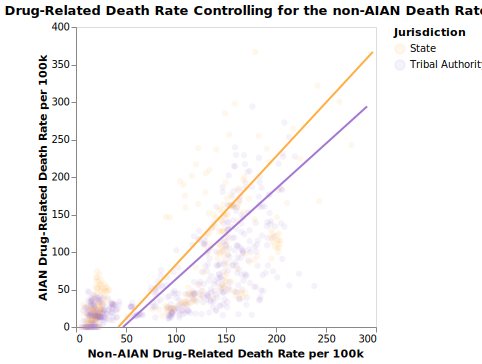

In [568]:
def state_regression_plot():
    df = AIAN_deaths
    chart = alt.Chart(df).mark_point(size = 40, filled=True, opacity = 0.1).encode(
        x = alt.X("drd_non_p100k:Q", title = "Non-AIAN Drug-Related Death Rate per 100k"),
        y = alt.Y("drd_AIAN_p100k:Q", title = "AIAN Drug-Related Death Rate per 100k"),
        color = alt.Color('Jurisdiction:N', scale=alt.Scale(
            domain = ["State", "Tribal Authority"],
            range = ["#FFAE42", "#a478d1"])))
    
    
    full_chart = chart + chart.transform_regression('drd_AIAN_p100k', 'drd_non_p100k',
                                              groupby = ['Jurisdiction']).mark_line()
    
    full_chart = full_chart.properties(
        title = "AIAN Drug-Related Death Rate Controlling for the non-AIAN Death Rate",
        ).configure_axis(
        grid=False            
        )

    return full_chart

alt.renderers.enable("svg")
vis8 =state_regression_plot()
svg_str = vlc.vegalite_to_svg(vis8.to_json(), vl_version="5.20")
with open("vis8.svg", "wt") as f:
    f.write(svg_str)

vis8.save("vis8.png")
vis8

In [569]:
model_comp = pl.read_csv("data/model_comparison.csv")
model_comp = model_comp.with_columns(
    (pl.col("State Criminal Jurisdiction Coefficient Estimate") * 100000),
    (pl.col("CI_lower") * 100000),
    (pl.col("CI_upper") * 100000))


def show_comp(df):
    bar = alt.Chart(df).mark_errorbar().encode(
        alt.X("CI_upper:Q", title = ""),
        alt.X2("CI_lower:Q"),
        alt.Y("Model:N"),
    )

    point = alt.Chart(df).mark_point(
        filled=True,
        color="purple"
    ).encode(
        alt.X("State Criminal Jurisdiction Coefficient Estimate:Q", 
              title = "Difference in AIAN Drug-Related Death Rate per 100k Persons"),
        alt.Y("Model:N")
    )
    
    point_text = alt.Chart(df).mark_text(
        align='center',
        baseline='bottom',
        dy= -5 
    ).encode(
    x='State Criminal Jurisdiction Coefficient Estimate:Q',
    y='Model:N',
    text=alt.Text("State Criminal Jurisdiction Coefficient Estimate:Q"))

    bar_text_upper = alt.Chart(df).mark_text(
        align='center',
        baseline='bottom',
        dy= 15,
        dx = 5 
    ).encode(
    alt.X('CI_upper:Q'),
    y='Model:N',
    text=alt.Text("CI_upper:Q"))

    bar_text_lower = alt.Chart(df).mark_text(
        align='center',
        baseline='bottom',
        dy= 15,
        dx = -5 
    ).encode(
    alt.X('CI_lower:Q'),
    y='Model:N',
    text=alt.Text("CI_lower:Q"))

    chart = (bar + point).properties(
        title = "Estimated Difference in AIAN Drug-Related Deathrate In Counties Tribes Lack Criminal Jurisdiction",
        width = 300,
        height = 300
    ).configure_axis(
        grid=False,
                    
    )    
    return chart + point_text + bar_text_upper + bar_text_lower

vis9 = show_comp(model_comp)

vis9.save("vis9.svg")